In [5]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


# Define Functions

In [6]:
#normalize data frame
def normalize(df):
    #Number of photos
    df["num_photos"] = df["photos"].apply(len)
    #Number of features
    df["num_features"] = df["features"].apply(len)
    #Number of description words
    df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
    #Created time 
    df["created"] = pd.to_datetime(df["created"])
    df["created_year"] = df["created"].dt.year
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    #Manager ID
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df['manager_id'].values))
    df['manager_id'] = lbl.transform(list(df['manager_id'].values))
    #Building ID
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df['building_id'].values))
    df['building_id'] = lbl.transform(list(df['building_id'].values))

#add manager_skill
def manager_skill(x_train, y_train):
    temp = pd.concat([x_train.manager_id, pd.get_dummies(y_train)], axis=1).groupby('manager_id').mean()
    temp['count'] = x_train.groupby('manager_id').count().iloc[:,0]

    #compute skill
    temp['manager_skill'] = temp['high']*2 + temp['medium']
    
    return temp
    
#mean skill values
def mean_skill(temp):
    # get ixes for unranked managers...
    unranked_managers_ixes = temp['count']<5
    # ... and ranked ones
    ranked_managers_ixes = ~unranked_managers_ixes

    # compute mean values from ranked managers and assign them to unranked ones
    mean_values = temp.loc[ranked_managers_ixes, ['high','low','medium','manager_skill']].mean()
    # compute for unranked_managers_ixes
    temp.loc[unranked_managers_ixes,['high','low','medium','manager_skill']] = mean_values.values
    
    return mean_values

#price_per_bedroom
def price_per_bedroom(x):
    x['price_per_bedroom']=0;
    x.loc[:, 'price_per_bedroom'] = x.apply(lambda row: valuation_formula(row['bedrooms'], row['price']), axis=1)

#bedroom/bathroom
def bedratiobath(x):
    x['bed_bath_ratio']=0;
    x.loc[:, 'bed_bath_ratio'] = x.apply(lambda row: valuation_formula(row['bathrooms'], row['bedrooms']), axis=1)
    
def valuation_formula(x, y):
    if x>0:
        return y/x
    else:
        return y

# PreProcessing

In [7]:
#Read data from file
df = pd.read_json("train.json")
normalize(df)

In [8]:
initial_features = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day", "manager_id","building_id"]

x = df[initial_features]
y = df["interest_level"]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.01)

temp = manager_skill(x_train, y_train)
mean_values = mean_skill(temp)

In [9]:
x_train = x_train.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')

x_val = x_val.merge(temp.reset_index(), how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = x_val['high'].isnull()
x_val.loc[new_manager_ixes,['high','low', 'medium','manager_skill']] = mean_values.values

price_per_bedroom(x_train)
bedratiobath(x_train)
price_per_bedroom(x_val)
bedratiobath(x_val)

In [10]:
print(x_train.head())
x_train.to_csv("xtrain.csv")

   bathrooms  bedrooms  latitude  longitude  price  num_photos  num_features  \
0        1.0         1   40.7065   -74.0077   2695           6            15   
1        1.0         1   40.7462   -73.9759   2400           5             0   
2        3.0         3   40.7849   -73.9810  13995          15             7   
3        1.0         1   40.7196   -74.0095   7000          10            11   
4        1.0         0   40.7744   -73.9509   2049           3             0   

   num_description_words  created_year  created_month  created_day  \
0                    127          2016              4           15   
1                     24          2016              6           17   
2                    383          2016              4            7   
3                    180          2016              5           24   
4                     33          2016              6           16   

   manager_id  building_id      high       low    medium  count  \
0         354         5984  0.3

In [11]:
features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day", 'high','low','medium',
                   "building_id",'manager_id','manager_skill','price_per_bedroom','bed_bath_ratio']

# Make Prediction
## RandomForestClassifier

In [135]:
these_features = [f for f in features_to_use if f not in ["created_year", 'high','low','medium']]

# Random Forest Classification Tree
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(x_train[these_features], y_train)
y_val_pred = clf.predict_proba(x_val[these_features])
log_loss(y_val, y_val_pred)

0.57763216037619214

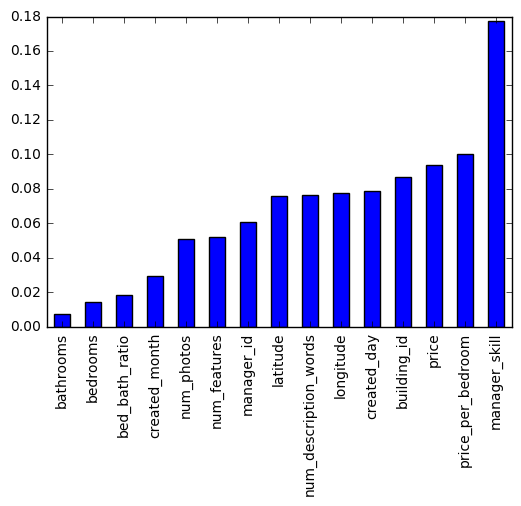

In [136]:
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

In [137]:
test = pd.read_json(open("test.json", "r"))
normalize(test)

In [138]:
x = test[initial_features]
x = x.merge(temp.reset_index(), how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = x['high'].isnull()
x.loc[new_manager_ixes,['high','low', 'medium','manager_skill']] = mean_values.values
price_per_bedroom(x)
bedratiobath(x)

In [139]:
y = clf.predict_proba(x[these_features])

In [140]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

{'high': 0, 'low': 1, 'medium': 2}

In [141]:
sub = pd.DataFrame()
sub["listing_id"] = test["listing_id"]
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]
sub.to_csv("submission.csv", index=False)